In [1]:
import pandas as pd
import numpy as np
from pymatgen.core import Composition

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,
    'axes.unicode_minus': False 
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300 

In [2]:
df_hse = pd.read_csv('./data/data.csv',index_col=0)
df_exp = pd.read_csv('./data/exp_data.csv')
df_hse['formula'] = df_hse['formula'].apply(lambda x: Composition(x).reduced_formula)
df_exp['formula'] = df_exp['formula'].apply(lambda x: Composition(x).reduced_formula)
merged = pd.merge(df_hse, df_exp[['formula', 'gap']], on='formula')

In [3]:
duplicated=merged['formula'].duplicated()

In [4]:
merged['duplicated'] = merged['formula'].duplicated()
merged = merged[merged['duplicated']==False]
merged

,formula,spacegroup,GGA,target,gap,duplicated
0,VO2,28.0,0.7988,0.798800,0.12,False
66,LiNi2(PO4)3,2.0,0.0000,0.000000,0.00,False
71,ScCrO4,63.0,0.0000,0.000000,0.00,False
73,KV4Ag11O16,61.0,0.8009,0.800900,2.00,False
74,LiMn(PO4)2,9.0,0.0000,0.000000,0.00,False
...,...,...,...,...,...,...
6521,ZrSe3,11.0,0.3979,1.038285,1.50,False
6522,ZrSi2,63.0,0.0000,0.000000,0.00,False
6523,ZrSiTe,129.0,0.0000,0.000000,0.00,False
6524,ZrTe,62.0,0.0000,0.000000,0.00,False


In [5]:
GGA_U_data = merged[merged['target']==merged['GGA']]
other_data = merged[merged['target']!=merged['GGA']]
GGA_U_data.shape,other_data.shape

((2621, 6), (1297, 6))

In [6]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_test = r2_score(merged['target'], merged['gap'])
mae = mean_absolute_error(merged['target'], merged['gap'])
rmse = mean_squared_error(merged['target'], merged['gap'], squared=False)
textstr = f'R2 = {r2_test:.2f} MAE = {mae:.2f}  RMSE = {rmse:.2f}'
textstr

'R2 = 0.69 MAE = 0.37  RMSE = 0.82'

In [7]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(merged['target'].values.reshape(-1, 1), merged['gap'].values.reshape(-1, 1))
ridge.coef_,ridge.intercept_

(array([[0.86906807]]), array([0.14514824]))

Text(0, 0.5, 'Experimental $E_{\\mathrm{g}}(eV)$')

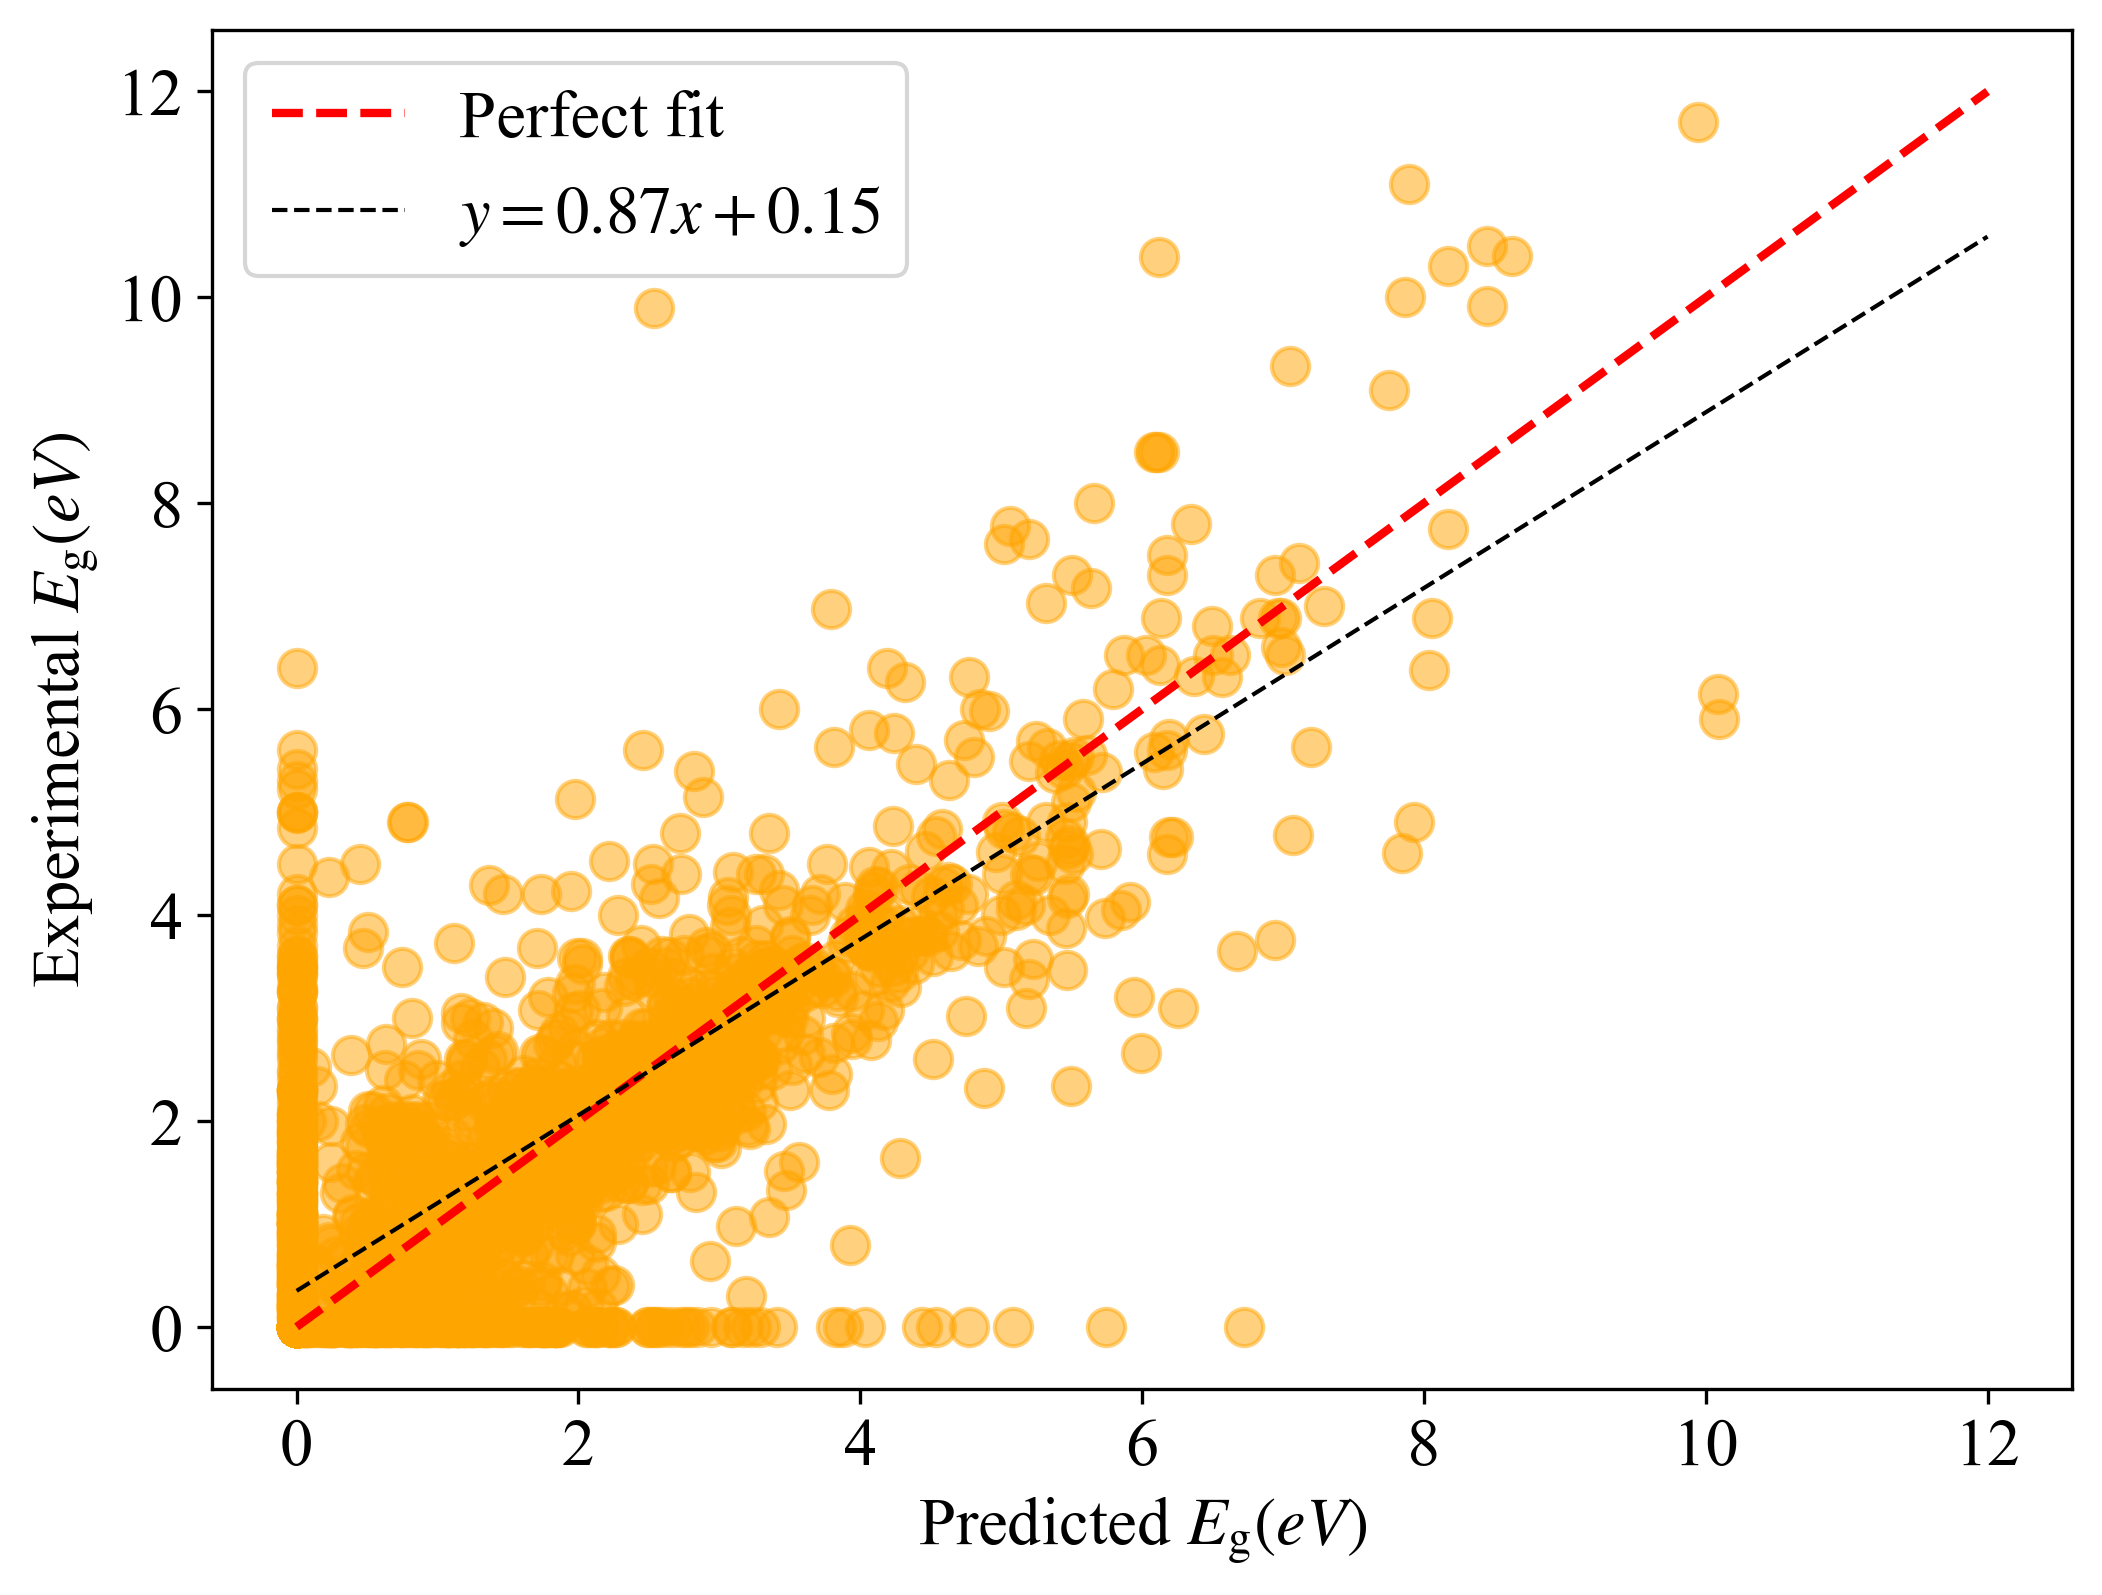

In [12]:
fig, ax = plt.subplots(figsize=(8,6),facecolor="w")
ax.scatter(merged['target'], merged['gap'], facecolor='orange',s=80,  alpha=0.5)
ax.plot([0, 12], [0, 12],  'r--',lw=2,label='Perfect fit')
ax.plot([0, 12], [0.35, 12*0.87+0.15],
        'k--', lw=1, label=r'$ y = 0.87 x + 0.15 $')
ax.legend()
ax.set_xlabel('Predicted '+ r'$E_{\mathrm{g}} (eV)$')
ax.set_ylabel('Experimental '+r'$E_{\mathrm{g}}(eV)$')

In [9]:
r2_test = r2_score(other_data['GGA'], other_data['gap'])
mae = mean_absolute_error(other_data['GGA'], other_data['gap'])
rmse = mean_squared_error(other_data['GGA'], other_data['gap'], squared=False)
textstr = f'R2 = {r2_test:.2f} MAE = {mae:.2f}  RMSE = {rmse:.2f}'
textstr

'R2 = 0.07 MAE = 0.91  RMSE = 1.28'

In [10]:
ridge = Ridge(alpha=1.0)
ridge.fit(other_data['GGA'].values.reshape(-1, 1), other_data['gap'].values.reshape(-1, 1))
ridge.coef_,ridge.intercept_

(array([[1.06452046]]), array([0.65883679]))

Text(0, 0.5, 'Experimental $E_{\\mathrm{g}}(eV)$')

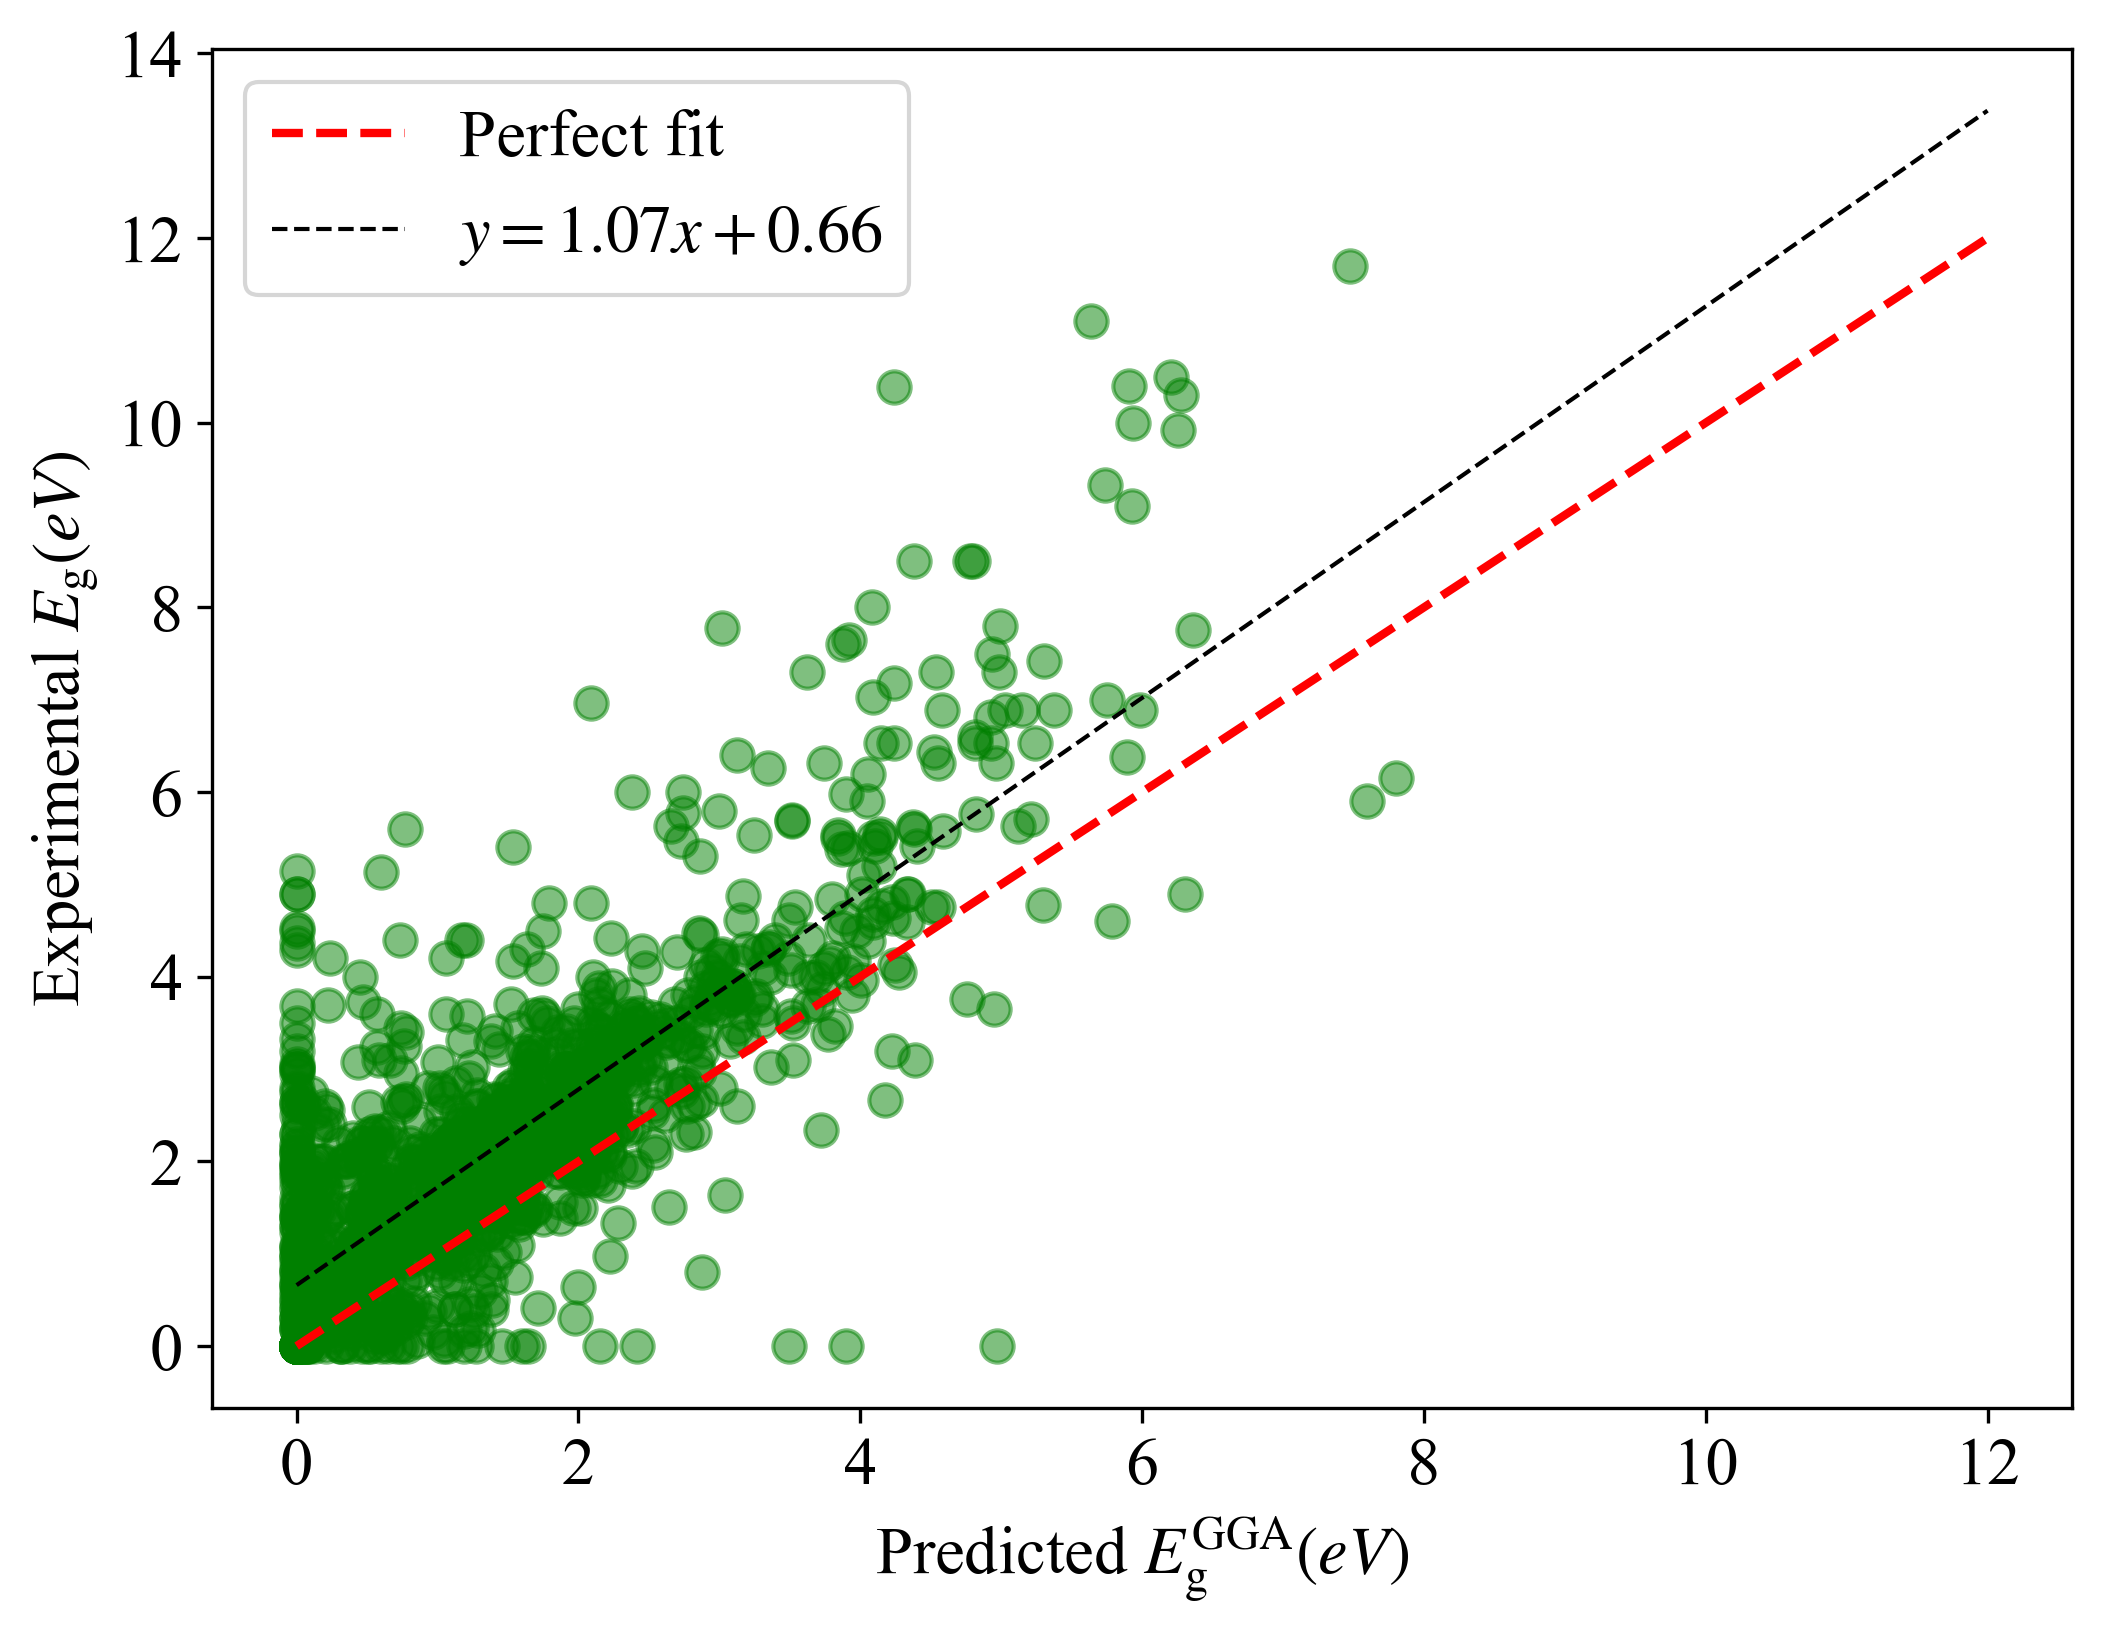

In [14]:
fig, ax = plt.subplots(figsize=(8,6),facecolor="w")
ridge.fit(other_data['GGA'].values.reshape(-1, 1), other_data['gap'].values.reshape(-1, 1))
ax.scatter(other_data['GGA'], other_data['gap'], facecolor='g',s=60,  alpha=0.5)
ax.plot([0, 12], [0, 12],  'r--',lw=2,label='Perfect fit')
ax.plot([0, 12], [0.66, 13.38],
        'k--', lw=1, label=r'$ y = 1.07x + 0.66 $')
ax.legend()
ax.set_xlabel('Predicted '+ r'$E_{\mathrm{g}}^{\mathrm{GGA}} (eV)$')
ax.set_ylabel('Experimental '+r'$E_{\mathrm{g}}(eV)$')